In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

import IPython.display as display

import numpy as np
import PIL.Image
import time
import functools

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]  # access the first matrix if (1, ..., ..., ...)
    return PIL.Image.fromarray(tensor)

In [3]:
# Get images from ./images
content_path = "images/nyc.jpg"
style_path = "images/starry_night.jpg"

In [4]:
def load_image(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # creates another dimension (1, ..., ..., 3)
    
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

tf.Tensor(
[[0.7602659  0.49752074 0.38379526]
 [0.7602659  0.49752074 0.38379526]
 [0.7602659  0.49752074 0.38379526]
 ...
 [0.70729166 0.781679   0.742402  ]
 [0.67922795 0.7694241  0.7380515 ]
 [0.6627451  0.75294125 0.72156864]], shape=(512, 3), dtype=float32)


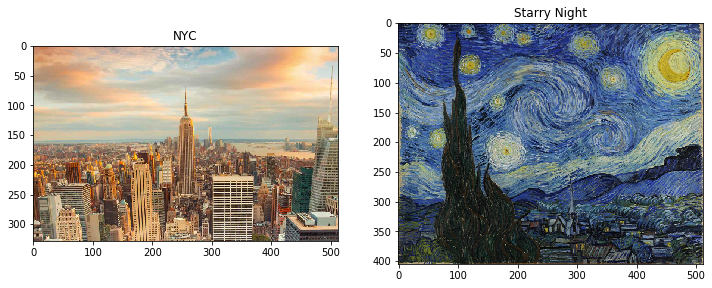

In [6]:
content_image = load_image(content_path)
style_image = load_image(style_path)

print(content_image[0, 0, :, :])

plt.subplot(1, 2, 1)
imshow(content_image, title="NYC")

plt.subplot(1, 2, 2)
imshow(style_image, title="Starry Night")

In [7]:
# Get VGG19 model and preprocess image for training
x = keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

vgg = keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

(1, 1000)


In [8]:
top_5_predictions = keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
print([(class_name, probs) for (number, class_name, probs) in top_5_predictions])

[('palace', 0.27254942), ('fountain', 0.19370638), ('cab', 0.07666853), ('church', 0.064511396), ('dock', 0.052324645)]


In [9]:
# Load VGG Layers without classification layer
vgg = keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
# Choose intermediate layers to represent the content and style for the generated image
content_layers = ["block4_conv2"]

style_layers = ["block1_conv1",
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def vgg_layers(layer_names):
    # Returns a list of layer_names and their outputs
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # freeze layers
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = keras.Model([vgg.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)  # extract ouputs from selected layers
style_outputs = style_extractor(style_image*255.0)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(f"shape: {output.numpy().shape}")
    print(f"min: {output.numpy().min()}")
    print(f"max: {output.numpy().max()}")
    print(f"mean: {output.numpy().mean()}")
    print()


block1_conv1
shape: (1, 405, 512, 64)
min: 0.0
max: 659.7158203125
mean: 23.813549041748047

block2_conv1
shape: (1, 202, 256, 128)
min: 0.0
max: 2951.323486328125
mean: 147.6482696533203

block3_conv1
shape: (1, 101, 128, 256)
min: 0.0
max: 7349.88671875
mean: 144.15646362304688

block4_conv1
shape: (1, 50, 64, 512)
min: 0.0
max: 16759.181640625
mean: 560.43505859375

block5_conv1
shape: (1, 25, 32, 512)
min: 0.0
max: 3788.5810546875
mean: 48.1234016418457



In [13]:
# Compute style by using Gram Matrix (outer product of itself generates correlation matrix)
def gram_matrix(input_tensor):
    # matrix of size (b,i,j,c) dot (b,i,j,d).T = (b,c,d) or n_C * (n_H * n_W) dot (n_H * n_W) * n_C = n_C x n_C
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    
    # input_shape[1], input_shape[2] = n_H, n_W
    num_locations = (2 * tf.cast(input_shape[1]*input_shape[2], tf.float32)) ** 2
    
    return result / num_locations

In [14]:
# Class the returns the style in gram matrix and content of the image
class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        "Expects input image of float [0, 1]"
        inputs = inputs*255.0
        preprocessed_inputs = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
    
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print("Style: ")
for name, output in sorted(results['style'].items()):
    print(f"  {name}")
    print(f"  shape: {output.numpy().shape}")
    print(f"  min: {output.numpy().min()}")
    print(f"  max: {output.numpy().max()}")
    print(f"  mean: {output.numpy().mean()}")
    print()
    
print("Content: ")
for name, output in sorted(results['content'].items()):
    print(f"  {name}")
    print(f"  shape: {output.numpy().shape}")
    print(f"  min: {output.numpy().min()}")
    print(f"  max: {output.numpy().max()}")
    print(f"  mean: {output.numpy().mean()}")
    print()

Style: 
  block1_conv1
  shape: (1, 64, 64)
  min: 1.871289185828573e-07
  max: 0.052653905004262924
  mean: 0.0008619422442279756

  block2_conv1
  shape: (1, 128, 128)
  min: 0.0
  max: 1.7252565622329712
  mean: 0.11610808968544006

  block3_conv1
  shape: (1, 256, 256)
  min: 0.0
  max: 26.26445770263672
  mean: 0.4923684000968933

  block4_conv1
  shape: (1, 512, 512)
  min: 0.0
  max: 929.6079711914062
  mean: 29.688589096069336

  block5_conv1
  shape: (1, 512, 512)
  min: 0.0
  max: 43.93586349487305
  mean: 0.8466261029243469

Content: 
  block4_conv2
  shape: (1, 41, 64, 512)
  min: 0.0
  max: 17367.822265625
  mean: 331.2991027832031



In [16]:
# Get target style and target content using by running the images through the extractor
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [17]:
# Initialize a generated image of the same size as the content_image, to optimzie make it a Variable
# and to make it quicker, initialize it as the content_image
image = tf.Variable(content_image)

In [18]:
# Since the image is a float image, clip values to be [0, 1]
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [39]:
# Create an optimizer, paper uses LBFGS but Adam works fine
opt = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)

In [20]:
# Set weighted values of content and style to appear in the generated image
style_weight = 40
content_weight = 10

In [21]:
def style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(style_outputs[name] - style_targets[name])**2 
                           for name in style_outputs.keys()])
    style_loss *= style_weight * style_loss
    
    content_loss = tf.add_n([tf.reduce_mean(content_outputs[name] - content_targets[name])**2
                            for name in content_outputs.keys()])
    content_loss *= content_weight * content_loss
    
    loss = style_loss + content_loss
    return loss

In [22]:
# Reset image
image = tf.Variable(content_image)

In [23]:
# Regularization weight to reduce high frequency variations / artifacts
total_variation_weight = 30

In [24]:
# Record operations to calculate automatic differentiation (ie. 1 step of gradient descent)
def train_step(image, content_targets, style_targets, content_weight, style_weight, total_variation_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)  # pass generated image into the network and get outputs
        
        # calculate the loss function
        loss = style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)  # loss will be differentiated against the pixels in image
    opt.apply_gradients([(grad, image)])  # apply grads calculated to image
    image.assign(clip_0_1(image))  # assign image to a new clipped image after applying gradients
    
    return loss

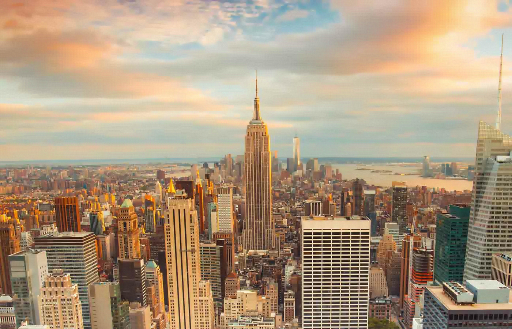

In [25]:
train_step(image, content_targets, style_targets, 1e-5, 1e-2, 50)
train_step(image, content_targets, style_targets, 1e-5, 1e-2, 50)
tensor_to_image(image)

In [36]:
def train(image, epochs, content_targets, style_targets, content_weight, style_weight, total_variation_weight, steps_per_epoch=100):
    step = 0
    display.display(tensor_to_image(image))
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            loss = train_step(image, content_targets, style_targets, content_weight, style_weight, total_variation_weight)
            
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print(f"Train step: {step}, loss: {loss}")
    
    return image

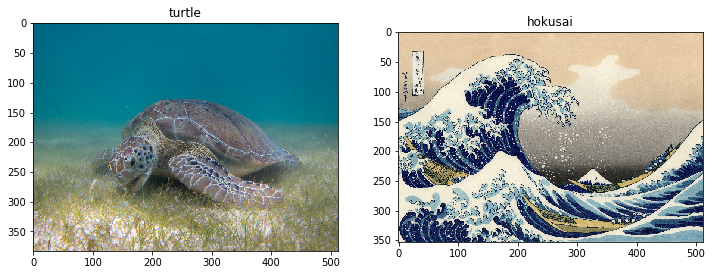

In [33]:
content_path = "images/turtle.jpg"
style_path = "images/hokusai.jpg"

# Get image from its respective paths
content_image = load_image(content_path)
style_image = load_image(style_path)

# Display images to be synthesized
plt.subplot(1, 2, 1)
imshow(content_image, title=content_path[7:-4])

plt.subplot(1, 2, 2)
imshow(style_image, title=style_path[7:-4])

In [34]:
def NST(content_image, style_image, reset=True, epochs=10, steps_per_epoch=1, content_weight=1e4, style_weight=0.02, total_variation_weight=30):
    # Extract target content and styles
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    
    # Initialize image
    if reset:
        image = tf.Variable(content_image)
    else:
        noise = np.random.uniform(-20, 20, tf.shape(content_image)).astype('float32')
        image  = noise * 0.6 + content_image * (1 - noise)
        image = tf.Variable(image)
        
    # Start training
    image = train(image, epochs, content_targets, style_targets, content_weight, style_weight, total_variation_weight, steps_per_epoch=steps_per_epoch)
    
    return image

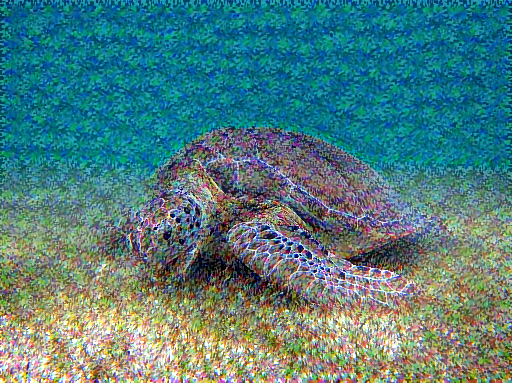

Train step: 1000, loss: [3863410.8]


In [40]:
image = NST(content_image, style_image, epochs=10, reset=True, steps_per_epoch=100, content_weight=1e-2, style_weight=1e3, total_variation_weight=30)

In [41]:
file_name='turtle_hokusai_(1e-2,1e3,30,lr0.002).png'
tensor_to_image(image).save(file_name)